A short introduction to fast SPT modeling
-----------------------------------------

This notebook presents a short introduction to the modeling of fast single particle tracking datasets. 
The methodology, together with examples of biological relevance, can be found at:

> Hansen, Anders S., Iryna Pustova, Claudia Cattoglio, Robert Tjian, and Xavier Darzacq. “CTCF and Cohesin Regulate Chromatin Loop Stability with Distinct Dynamics.” bioRxiv, 2016, 093476.

This package includes several sample datasets, that will be used by this notebook. Make sure that they can be found by Python.

## 1. Loading of a dataset

To help us with basic and repeated tasks such as dataset loading, we created a small library, `fastSPT_tools` that contain several helper functions that we will use all across this tutorial. We thus need to import it by typing `import fastSPT_tools`.

One of the functions list the available datasets: `list_sample_datasets(path)`. Let's first see what datasets we can get. Then, we will use the `load_dataset(path, dataset_id, cells)` function to load the relevant dataset. This latter function can either load one single cell or a series of cells (identified by their id).

In [3]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import fastspt as fs
from fastspt import fit, tools, plot, readers
#import fastspt.fastSPT_tools as fastSPT_tools
#import fastspt.fastSPT_plot as fastSPT_plot

%load_ext autoreload

%autoreload 2

print("Using fastspt version {}".format(fs.__version__))

#print(fastSPT_tools.list_sample_datasets(path="./datasets/"))
#print(fastSPT_tools.list_sample_datasets(path=r"Z:\Andrey\fromGizem\2018-11-01-TKL-fast\TKL-50mW-60msExp-FTon-obis5"))

Using fastspt version 16.0


In [6]:
cell0   = fs.tools.load_dataset("./datasets/", 1, 0) ## Load a single cell of dataset 1
cell1   = fs.tools.load_dataset("./datasets/", 1, 1) ## Load a single cell of dataset 1
cellall = fs.tools.load_dataset("./datasets/", 1, [0,1,2,3,4,5,6,7]) ## Load all the cells of dataset 1

AttributeError: module 'datasets' has no attribute 'list'

In [31]:
path = r"Z:\Andrey\data\2019\0403-RAMM-e-coli-pbp2-PAmCherry-TLK130\100x_1.49NA_Cold_mirror_unscrewed_FF-quad-band\0403_OD0.1\FOV1\movie_Ard_trig_v1.0_exp_60ms_561_50W_30ms_405_12.5mW_0.8ms_1\movie_Ard_trig_v1_Tracks.xml"

In [32]:
cell3   = readers.read_trackmate_xml(path)

In [33]:
cell3_spt = readers.to_fastSPT(cell3, from_json=False)

In [34]:
track_lengths = list(map(len, cell3))

Text(0, 0.5, 'counts')

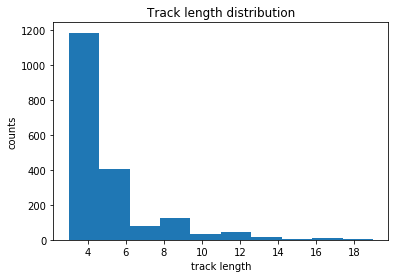

In [35]:
plt.hist(track_lengths)
plt.title('Track length distribution')
plt.xlabel('track length')
plt.ylabel('counts')

In [45]:
def plot_fit(fit_result):
    import numpy as np
    ## Generate the PDF corresponding to the fitted parameters
    y = fit.generate_jump_length_distribution(fit_result.params, 
                                                  JumpProb = JumpProbCDF, r=HistVecJumpsCDF,
                                                  LocError = fit_result.params['sigma'].value, 
                                                  dT = params['dT'], dZ = params['dZ'], 
                                                  a = params['a'], b = params['b'], norm=True, useZcorr=params['useZcorr'])
    ## Normalization does not work for PDF yet (see commented line in fastspt.py)
    if CDF1:
        y*=float(len(HistVecJumpsCDF))/float(len(HistVecJumps))
    plt.figure(figsize=(18,8)) # Initialize the plot
    plot.plot_histogram(HistVecJumps, JumpProb, HistVecJumpsCDF, y) ## Read the documentation of this function to learn how to populate all the 'na' fields

## 2. Computation of the jump lengths distribution

In [46]:
CDF=False
CDF1 = True
h1 = fit.compute_jump_length_distribution(cell3_spt, CDF=CDF1, useEntireTraj=False)

if CDF1:
    HistVecJumps = h1[2]
    JumpProb = h1[3]
    HistVecJumpsCDF = h1[0]
    JumpProbCDF = h1[1]
else:
    HistVecJumps = h1[0]
    JumpProb = h1[1]
    HistVecJumpsCDF = h1[0]
    JumpProbCDF = h1[1]

print("Computation of jump lengths performed in {:.2f}s".format(h1[-1]['time']))

Number of frames: 1000.0, number of localizations: 9142
Computation of jump lengths performed in 0.75s


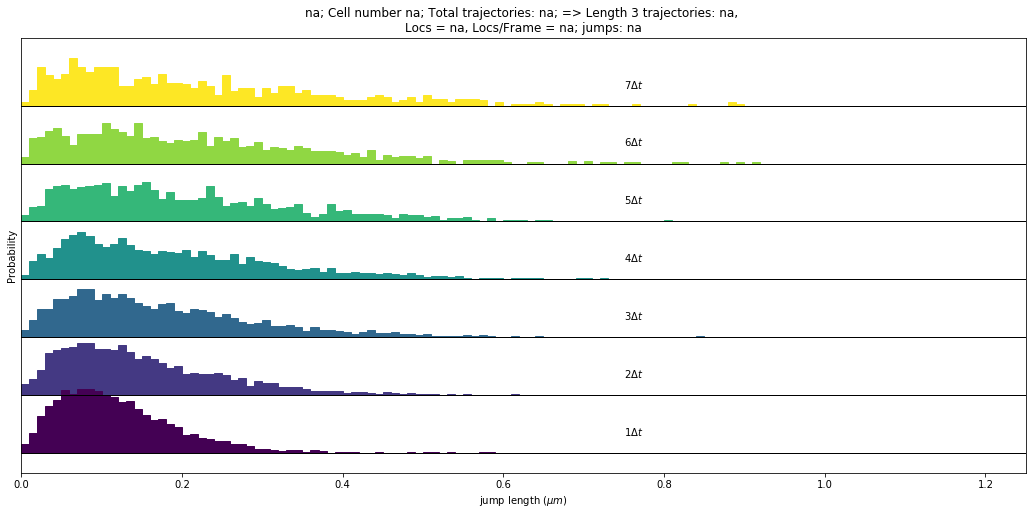

In [37]:
# Initialize the plot
plt.figure(figsize=(18,8))
plot.plot_histogram(HistVecJumps, JumpProb) ## Read the documentation of this function to learn how to populate all the 'na' fields

## 3. Fitting of the jump lengths distribution to the model (2 states)
### First with the localization error provided

precision extimate from TS MLE fit: 23 nm

Improved fit on iteration 1
Improved error is 9.92192638880341e-06
Name        Value      Min      Max   Stderr
D_bound  0.007108        0     0.02 0.0004192
D_free    0.06792     0.01      0.1 0.001497
F_bound    0.2411        0        1 0.009508
sigma        0.02     -inf      inf        0
None
Iteration 2 did not yield an improved fit
Iteration 3 did not yield an improved fit


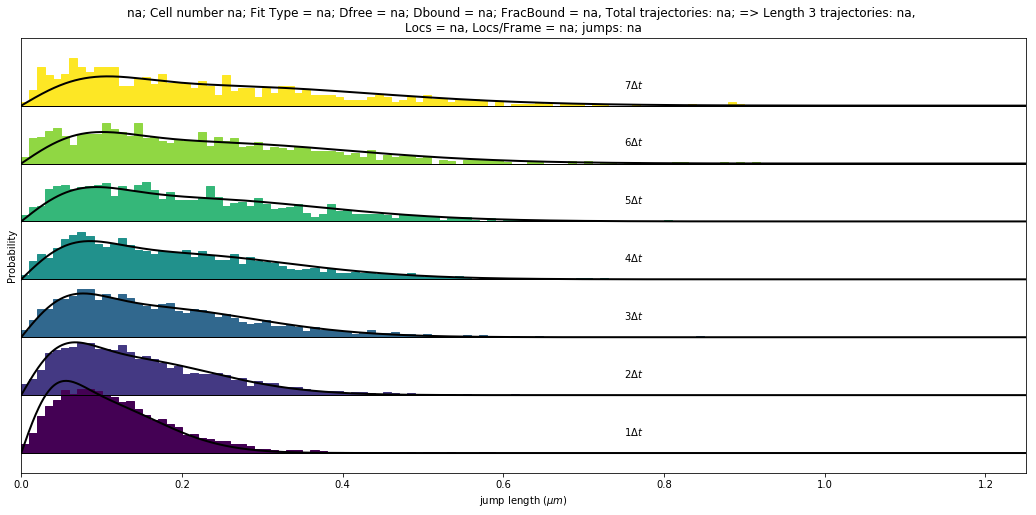

In [53]:
## First try a fit where sigma (LocError) is provided
#reload(fastspt)

## Generate a dictionary of parameters
Frac_Bound = [0, 1]
D_Free = [0.01, 0.1]
D_Bound = [0.000, 0.02]
LB = [D_Free[0], D_Bound[0], Frac_Bound[0]]
UB = [D_Free[1], D_Bound[1], Frac_Bound[1]]

params = {'UB': UB,
          'LB': LB,
          'LocError': 0.020, # Manually input the localization error in um: 35 nm = 0.035 um.
          'iterations': 3, # Manually input the desired number of fitting iterations:
          'dT': 65/1000, # Time between frames in seconds
          'dZ': 0.700, # The axial illumination slice: measured to be roughly 700 nm
          'ModelFit': [1,2][CDF],
          'fit2states': True,
          'a': 0.15716,
          'b': 0.20811,
          'useZcorr': False
}

## Perform the fit
fit_result = fit.fit_jump_length_distribution(JumpProb, JumpProbCDF, HistVecJumps, HistVecJumpsCDF, **params)
plot_fit(fit_result)

### Then by estimating the localization error from the data

Improved fit on iteration 1
Improved error is 5.627128089421488e-06
Name        Value      Min      Max   Stderr
D_bound  0.0003306        0     0.02 0.0003181
D_free    0.05719    0.001        1 0.001208
F_bound    0.2831        0        1  0.00738
sigma     0.04722    0.005      0.1 0.0008636
None
Iteration 2 did not yield an improved fit
Iteration 3 did not yield an improved fit


C:\Users\andre\Documents\Spot-On-cli\fastspt\fit.py:556: RuntimeWarning: invalid value encountered in true_divide
  norm_y[i,:] = y[i,:]/y[i,:].sum()


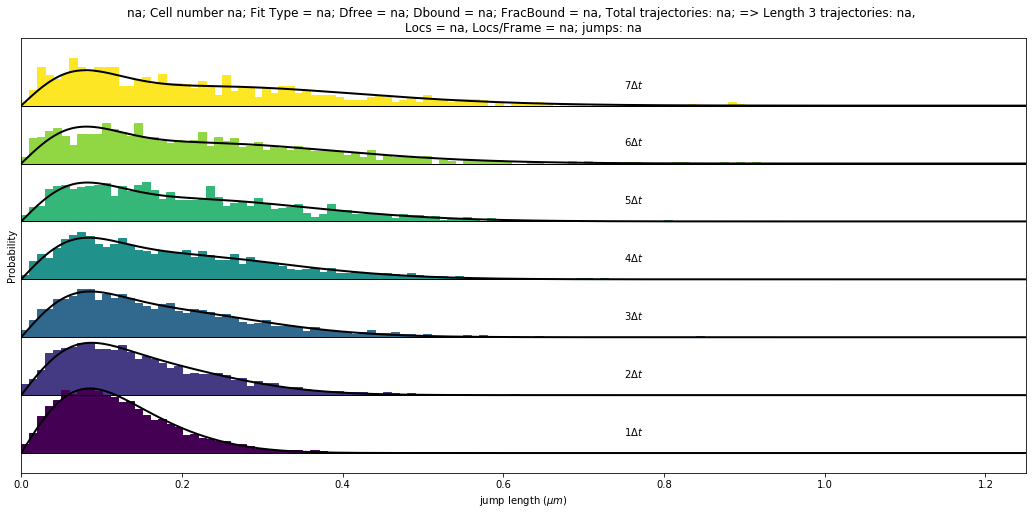

In [60]:
#reload(fastspt)

## Generate a dictionary of parameters
Frac_Bound = [0, 1]
D_Free = [0.001, 1]
D_Bound = [0.0, 0.02]
sigma_bound = [0.005, 0.1]                                   ## This line change
LB = [D_Free[0], D_Bound[0], Frac_Bound[0], sigma_bound[0]]  ## This line too
UB = [D_Free[1], D_Bound[1], Frac_Bound[1], sigma_bound[1]]  ## And this line

params = {'UB': UB,
          'LB': LB,
          'LocError': None, # Manually input the localization error in um: 35 nm = 0.035 um.
          'iterations': 3, # Manually input the desired number of fitting iterations:
          'dT': 65/1000, # Time between frames in seconds
          'dZ': 0.700, # The axial illumination slice: measured to be roughly 700 nm
          'ModelFit': [1,2][CDF],
          'fit2states': True,
          'fitSigma': True,
          'a': 0.15716,
          'b': 0.20811,
          'useZcorr': False
}

## Perform the fit
fit_result = fit.fit_jump_length_distribution(JumpProb, JumpProbCDF, HistVecJumps, HistVecJumpsCDF, **params)
plot_fit(fit_result)
fit_result

In [59]:

(fit_result)

The result of the fit has been stored in the `fit_result` variable. We can now plot the fitted results overlaid with the empirical distribution.

In [18]:
len(HistVecJumps), len(HistVecJumpsCDF), float(len(HistVecJumpsCDF))/float(len(HistVecJumps)), CDF1

(126, 1251, 9.928571428571429, True)

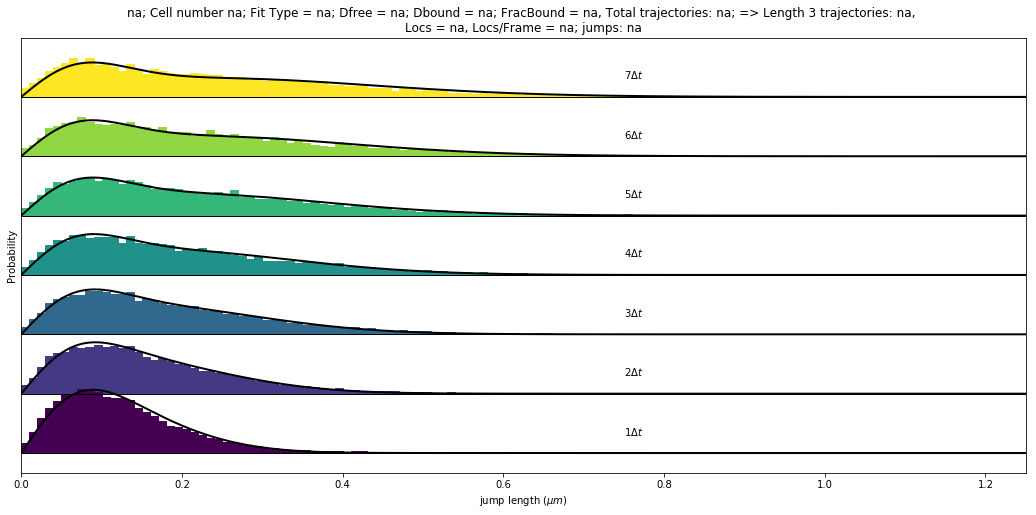

In [19]:
## And perform the plot
#reload(fastSPT_plot)

plt.figure(figsize=(18,8)) # Initialize the plot
plot.plot_histogram(HistVecJumps, JumpProb, HistVecJumpsCDF, y) ## Read the documentation of this function to learn how to populate all the 'na' fields

## 4. Fitting of the jump lengths distribution to the model (3 states)
### By providing the localization error

In [21]:
## Generate a dictionary of parameters
Frac_Bound = [0, 1]
Frac_Fast = [0, 1]
D_Fast = [0.01, 0.5]
D_Med = [0.01, 0.1]
D_Bound = [0.0005, 0.08]
LB = [D_Fast[0], D_Med[0], D_Bound[0], Frac_Fast[0], Frac_Bound[0]]
UB = [D_Fast[1], D_Med[1], D_Bound[1], Frac_Fast[1], Frac_Bound[1]]

params = {'UB': UB,
          'LB': LB,
          'LocError': 0.023, # Manually input the localization error in um: 35 nm = 0.035 um.
          'iterations': 3, # Manually input the desired number of fitting iterations:
          'dT': 60/1000, # Time between frames in seconds
          'dZ': 0.700, # The axial illumination slice: measured to be roughly 700 nm
          'ModelFit': [1,2][CDF],
          'fit2states': False,
          'a': 0.15716,
          'b': 0.20811,
          'useZcorr': False
}

## Perform the fit
fit_result = fs.fit.fit_jump_length_distribution(JumpProb, JumpProbCDF, HistVecJumps, HistVecJumpsCDF, **params)

Improved fit on iteration 1
Improved error is 4.761174345663751e-06
Name        Value      Min      Max   Stderr
D_bound   0.07651   0.0005     0.08     None
D_fast        0.5     0.01      0.5     None
D_med        0.01     0.01      0.1     None
F_bound    0.6843        0        1     None
F_fast    0.05733        0        1     None
sigma       0.023     -inf      inf     None
None
Improved fit on iteration 2
Improved error is 4.482606346976106e-06
Name        Value      Min      Max   Stderr
D_bound  0.005321   0.0005     0.08 0.0005165
D_fast     0.1189     0.01      0.5  0.01161
D_med     0.04149     0.01      0.1 0.005448
F_bound     0.161        0        1  0.01333
F_fast     0.4232        0        1  0.07314
sigma       0.023     -inf      inf        0
None
Iteration 3 did not yield an improved fit


In [24]:
import numpy as np
## Generate the PDF corresponding to the fitted parameters

y = fs.fit.generate_jump_length_distribution(fit_result.params,
                                              JumpProb = JumpProb, r=HistVecJumpsCDF,
                                              LocError = fit_result.params['sigma'].value, 
                                              dT = params['dT'], dZ = params['dZ'], 
                                              a = params['a'], b = params['b'], 
                                              fit2states = params['fit2states'], useZcorr=params['useZcorr'])
## Normalize it
norm_y = np.zeros_like(y)
for i in range(y.shape[0]): # Normalize y as a PDF
    norm_y[i,:] = y[i,:]/y[i,:].sum()
scaled_y = (float(len(HistVecJumpsCDF))/len(HistVecJumps))*norm_y #scale y for plotting next to histograms

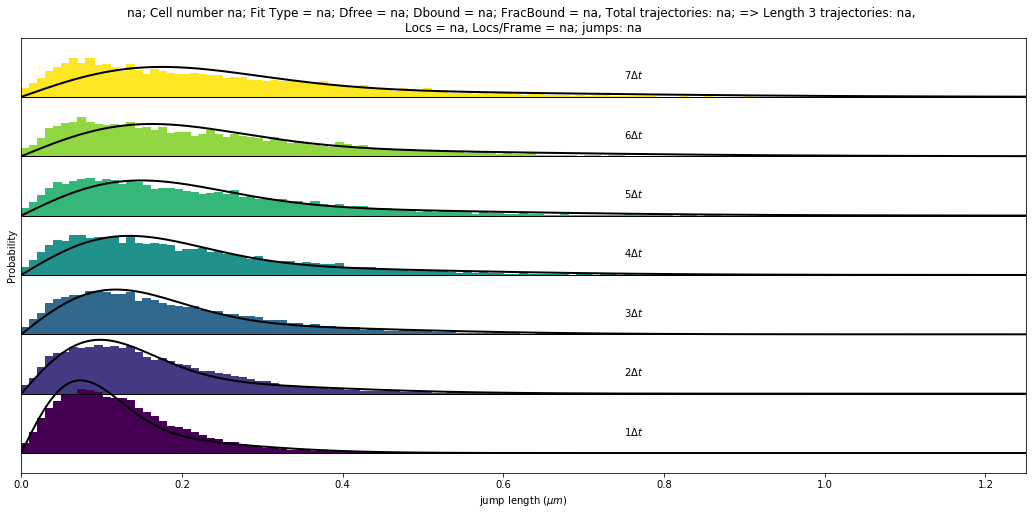

In [25]:
plt.figure(figsize=(18,8)) # Initialize the plot
fs.plot.plot_histogram(HistVecJumps, JumpProb, HistVecJumpsCDF, scaled_y) ## Read the documentation of this function to learn how to populate all the 'na' fields

### By fitting the localization error

In [12]:
## Generate a dictionary of parameters
Frac_Bound = [0, 1]
Frac_Fast = [0, 1]
D_Fast = [0.15, 25]
D_Med = [0.15, 10]
D_Bound = [0.0005, 0.08]
sigma_bound = [0.005, 0.1] 
LB = [D_Fast[0], D_Med[0], D_Bound[0], Frac_Fast[0], Frac_Bound[0], sigma_bound[0]]
UB = [D_Fast[1], D_Med[1], D_Bound[1], Frac_Fast[1], Frac_Bound[1], sigma_bound[1]]

params = {'UB': UB,
          'LB': LB,
          'LocError': None, # Manually input the localization error in um: 35 nm = 0.035 um.
          'iterations': 3, # Manually input the desired number of fitting iterations:
          'dT': 4.477/1000, # Time between frames in seconds
          'dZ': 0.700, # The axial illumination slice: measured to be roughly 700 nm
          'ModelFit': [1,2][CDF],
          'fit2states': False,
          'fitSigma': True,
          'a': 0.15716,
          'b': 0.20811,
          'useZcorr': True
}

## Perform the fit
fit = fastspt.fit_jump_length_distribution(JumpProb, JumpProbCDF, HistVecJumps, HistVecJumpsCDF, **params)

Improved fit on iteration 1
Improved error is 5.34777986914e-06
Name        Value      Min      Max   Stderr
D_bound  0.003055   0.0005     0.08 0.001691
D_fast      3.964     0.15       25   0.3079
D_med      0.3139     0.15       10  0.04158
F_bound    0.5223        0        1  0.01129
F_fast     0.2916        0        1 0.009771
sigma     0.04025    0.005      0.1 0.0003739
None
Iteration 2 did not yield an improved fit
Improved fit on iteration 3
Improved error is 5.34777986914e-06
Name        Value      Min      Max   Stderr
D_bound  0.003055   0.0005     0.08 0.001691
D_fast      3.964     0.15       25   0.3079
D_med      0.3139     0.15       10  0.04158
F_bound    0.5223        0        1  0.01129
F_fast     0.2916        0        1 0.009771
sigma     0.04025    0.005      0.1 0.0003739
None


In [15]:
y = fastspt.generate_jump_length_distribution(fit.params,
                                              JumpProb = JumpProb, r=HistVecJumpsCDF,
                                              LocError = fit.params['sigma'], 
                                              dT = params['dT'], dZ = params['dZ'], 
                                              a = params['a'], b = params['b'], 
                                              fit2states = params['fit2states'], useZcorr=params['useZcorr'])
## Normalize it
norm_y = np.zeros_like(y)
for i in range(y.shape[0]): # Normalize y as a PDF
    norm_y[i,:] = y[i,:]/y[i,:].sum()
scaled_y = (float(len(HistVecJumpsCDF))/len(HistVecJumps))*norm_y #scale y for plotting next to histograms

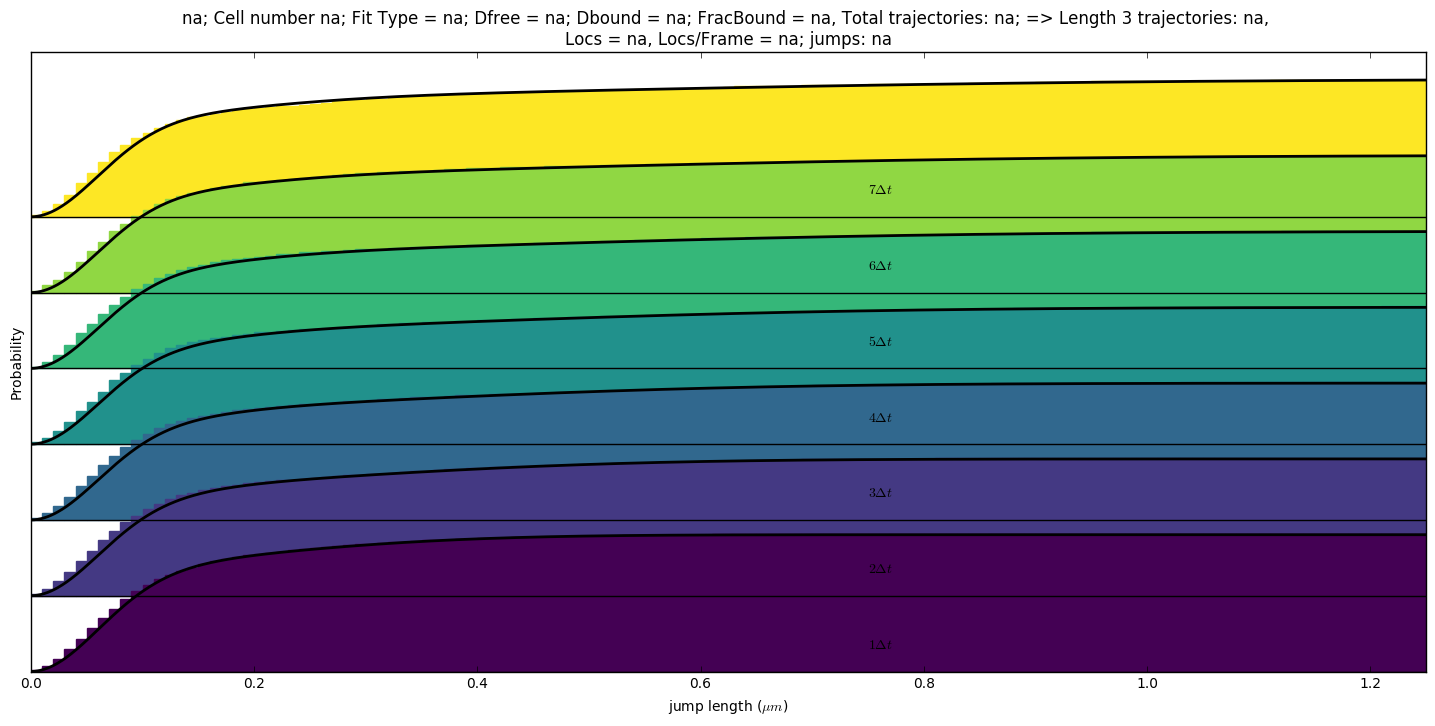

In [16]:
# Plot the CDF
plt.figure(figsize=(18,8)) # Initialize the plot
#plt.plot(JumpProbCDF[0,:])
fastSPT_plot.plot_histogram(HistVecJumps, np.cumsum(JumpProb, axis=1)/10., HistVecJumpsCDF, np.cumsum(scaled_y, axis=1)/100.) ## Read the documentation of this function to learn how to populate all the 'na' fields